In [1]:
import seaborn as sns 
from matplotlib import pyplot as plt 
import pandas as pd
import numpy as np
import nltk 
from scipy import stats
from collections import Counter

In [2]:
# import expanded filtered quote file (after sentiment & stance analysis)
# quotes_expanded = pd.read_json("filtered.json") #we would replace the file here by the pickle containing sentiment + stance
quotes_expanded = pd.read_pickle("added_sentiment.pkl")
quotes_expanded = quotes_expanded.reset_index(drop=True)

df_time = quotes_expanded[['quote_year','quote_month']]
df_time['quote_day'] = np.ones(len(df_time), dtype = int)
df_time.columns = ['year', 'month', 'day']
df_time = pd.to_datetime(df_time)
quotes_expanded["quote_date"] = df_time
quotes_expanded = quotes_expanded.drop(['numOccurrences','quote_year', 'quote_month','occupation'], axis=1)

quotes_expanded.gender = [elem[0] for elem in quotes_expanded.gender]
quotes_expanded.nationality = [elem[0] for elem in quotes_expanded.nationality]

quotes_expanded.head(10)

<ipython-input-2-fe1ef84a60cb>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time['quote_day'] = np.ones(len(df_time), dtype = int)


,date_of_birth,nationality,gender,Speaker,Quote,Sentiment,quote_date
0,1971,United States of America,female,sarah kate ellis,This loss is a wake-up call that despite remar...,-0.8760,2015-11-01
1,1971,United States of America,female,sarah kate ellis,"She didn't see it, she hadn't heard of it, she...",0.0387,2015-06-01
2,1971,United States of America,female,sarah kate ellis,As a journalist and anchor who reaches million...,0.4939,2015-04-01
3,1971,United States of America,female,sarah kate ellis,By empowering people to talk about their gende...,0.7003,2015-02-01
4,1971,United States of America,female,sarah kate ellis,"By investing in this dangerous programming, TL...",-0.5610,2015-01-01
5,1971,United States of America,female,sarah kate ellis,attitudes within the Catholic Church towards t...,0.0000,2015-09-01
6,1971,United States of America,female,sarah kate ellis,showing that many Americans think that we've a...,0.4588,2015-12-01
7,1971,United States of America,female,sarah kate ellis,These ads have the potential to accelerate muc...,0.4588,2015-12-01
8,1971,United States of America,female,sarah kate ellis,"By sharing this story, Bruce Jenner has shined...",0.7579,2015-04-01
9,1971,United States of America,female,sarah kate ellis,We need to push media companies and creators t...,0.0000,2015-09-01


## 1) How legalization of same-sex marriage influenced the opinion of the authors of the quotes?

## Warning : 
### In the first part, we will perform the analysis on the whole dataset we picked for gender norms, rather than exclusively the same-sex marriage part (in a second time)

Answer roadmap : 
- 1 : Start with countries list
- 2 : Make up a table indicating the gay marriage legalization year
- 3 : Keep only a dataset where countries satisfies both [legalization year between 2015 and 2020] + [there are quotes both before and after the legalization]
- 4 : Compare pairs of means : country mean score before legalization VS after
- 5 : Test the null for each pair
- 6 : Conclude

## Part 1 : Answering our research question 1 with the full dataset

### Step 1

In [3]:
nationalities = np.hstack(quotes_expanded.nationality.dropna().to_numpy())
nationalities_dict = dict(Counter(nationalities))
nationalities_dict = {'Country': list(nationalities_dict.keys()), 'Counts': list(nationalities_dict.values())}
nationalities_df = pd.DataFrame.from_dict(nationalities_dict)
nationalities_df = nationalities_df.sort_values(by='Counts', ascending=False)

In [4]:
nationalities_df.head(10)

,Country,Counts
0,United States of America,70307
2,United Kingdom,14561
1,Australia,7230
3,Canada,4475
6,India,2585
8,Philippines,2020
4,Ireland,1672
29,New Zealand,894
24,Germany,689
11,South Africa,685


In [5]:
nationalities_df.tail(10)

,Country,Counts
158,British America,2
157,Kingdom of Afghanistan,2
154,Bhutan,2
153,Ecuador,2
180,Kingdom of France,2
164,Ukrainian Soviet Socialist Republic,1
162,Flor,1
173,Guam,1
174,Kingdom of Italy,1
144,Belarus,1


In [6]:
nationalities_df.Counts.mean()

633.9005524861878

In [7]:
nationalities_short = nationalities_df[nationalities_df['Counts'] > 1000]
nationalities_short = nationalities_short.reset_index(drop=True)

In [8]:
nationalities_short.head(10)

,Country,Counts
0,United States of America,70307
1,United Kingdom,14561
2,Australia,7230
3,Canada,4475
4,India,2585
5,Philippines,2020
6,Ireland,1672


In [9]:
nationalities_short = nationalities_short.drop(index=5)
nationalities_short = nationalities_short.reset_index(drop=True)
nationalities_short.head(10)

,Country,Counts
0,United States of America,70307
1,United Kingdom,14561
2,Australia,7230
3,Canada,4475
4,India,2585
5,Ireland,1672


*Philippines* were dropped because of the numerous changes detailed below, which will let us analyze them in a separate task.

Same-sex marriage is still not legal in *Philippines*, and, as stated in the initial analysis, this topic has know a bigh number of ups and downs :
- Anti-same sex marriage bills have been introduced to the Senate and Congress in 2006,
- A Presidential Palace spokesperson commented on same-sex marriage in 2014 saying "We must respect the rights of individuals to enter into such partnerships as part of their human rights",
- During his presidential campaign in February 2016, Rodrigo Duterte announced that should he win the election he would consider legalizing same-sex marriage, 
- On March 2017, however, Duterte said that he personally opposes same-sex marriage,
- On December 2017, Duterte changed his position on the issue, expressing his support again, guaranteeing that, during his term, the rights of LGBT people in the Philippines would be protected,
- On June 2018, the Philippine Supreme Court heard oral arguments, seeking to legalize same-sex marriage,
- On September 2019, the court dismissed the case for lack of standing.

For this purpose, 6 periods could be analyzed for *Philippines*, instead of 2 :
- January 2015 - January 2016,
- February 2016 - February 2017,
- March 2017 - November 2017,
- December 2017 - May 2018,
- June 2018 - August 2019,
- September 2019 - December 2020.

### Step 2

In [109]:
dates = pd.DataFrame({'year':[2015,2014,2017,2005,2017,2015],'month':[7,3,12,7,8,11],'day': [1,1,1,1,1,1]})
nationalities_short['Legalization_date'] = pd.to_datetime(dates)
nationalities_short.head(10)

,Country,Counts,Legalization_date
0,United States of America,70307,2015-07-01
1,United Kingdom,14561,2014-03-01
2,Australia,7230,2017-12-01
3,Canada,4475,2005-07-01
4,India,2585,2017-08-01
5,Ireland,1672,2015-11-01


Note *India* has not legalized gay marriage, however, such sexual orientations can be expressed from the annotated date (August 2017), and consensual sex activies are legal from September 2018.

### Steps 3-4-6

In [110]:
quotes_USA = quotes_expanded[quotes_expanded['nationality'] == 'United States of America']
quotes_UK = quotes_expanded[quotes_expanded['nationality'] == 'United Kingdom']
quotes_AUS = quotes_expanded[quotes_expanded['nationality'] == 'Australia']
quotes_IND = quotes_expanded[quotes_expanded['nationality'] == 'India']
quotes_IRE = quotes_expanded[quotes_expanded['nationality'] == 'Ireland']

nationalities_short = nationalities_short.drop(index=[1,3])
nationalities_short = nationalities_short.reset_index(drop=True)

Given the Quotebank available data starting in January 2015 and ending in December 2020, we won't be able to test the desired hypothesis for United Kingdom and Canada.

#### United States of America 

Starting with USA, even if the final legalization took place in June 2015, most States did already legalize it previously.
Thus, we do not expect to see a big influence here.

Ttest_indResult(statistic=6.862177181258093, pvalue=6.837817670767418e-12)
Average USA sentiment before legalization : 0.1632 , SD = 0.5114 , N = 7323
Average USA sentiment after legalization : 0.1179 , SD = 0.5369 , N = 62984
Overall average USA sentiment : 0.1227 , SD = 0.5344 , N = 70307


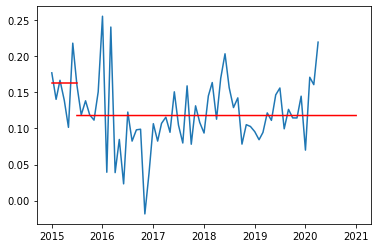

In [111]:
quotes_USA = quotes_USA.set_index(['quote_date'])
quotes_USA_before = quotes_USA.loc['2015-1-1' : '2015-6-30']
quotes_USA_after = quotes_USA.loc['2015-7-1' : '2020-12-31']
print(stats.ttest_ind(quotes_USA_before['Sentiment'], quotes_USA_after['Sentiment']))
print("Average USA sentiment before legalization :", round(quotes_USA_before['Sentiment'].mean(),4), ", SD =", round(quotes_USA_before['Sentiment'].std(),4) , ", N =",quotes_USA_before['Sentiment'].size)
print("Average USA sentiment after legalization :", round(quotes_USA_after['Sentiment'].mean(),4), ", SD =", round(quotes_USA_after['Sentiment'].std(),4) , ", N =",quotes_USA_after['Sentiment'].size)
print("Overall average USA sentiment :", round(quotes_USA['Sentiment'].mean(),4), ", SD =", round(quotes_USA['Sentiment'].std(),4) , ", N =",quotes_USA['Sentiment'].size)
plt.plot(quotes_USA.groupby('quote_date').mean()["Sentiment"])
plt.plot(pd.date_range(start="2015-1-1",end="2015-6-30"),quotes_USA_before['Sentiment'].mean() * np.ones(1+(pd.to_datetime("2015-6-30")-pd.to_datetime("2015-1-1")).days),'r')
plt.plot(pd.date_range(start="2015-7-1",end="2020-12-31"),quotes_USA_after['Sentiment'].mean() *np.ones(1+(pd.to_datetime("2020-12-31")-pd.to_datetime("2015-7-1")).days),'r')

### Australia

Ttest_indResult(statistic=3.4937570326145533, pvalue=0.00047912651617818046)
Average Australia sentiment before legalization : 0.1635 , SD = 0.5148 , N = 4376
Average Australia sentiment after legalization : 0.1196 , SD = 0.5331 , N = 2854
Overall average Australia sentiment : 0.1462 , SD = 0.5225 , N = 7230


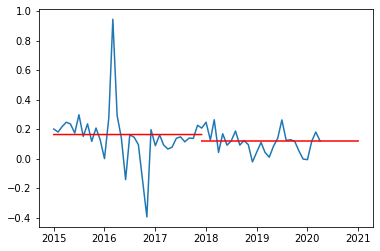

In [112]:
quotes_AUS = quotes_AUS.set_index(['quote_date'])
quotes_AUS_before = quotes_AUS.loc['2015-1-1' : '2017-11-30']
quotes_AUS_after = quotes_AUS.loc['2017-12-1' : '2020-12-31']
print(stats.ttest_ind(quotes_AUS_before['Sentiment'], quotes_AUS_after['Sentiment']))
print("Average Australia sentiment before legalization :", round(quotes_AUS_before['Sentiment'].mean(),4), ", SD =", round(quotes_AUS_before['Sentiment'].std(),4) , ", N =",quotes_AUS_before['Sentiment'].size)
print("Average Australia sentiment after legalization :", round(quotes_AUS_after['Sentiment'].mean(),4), ", SD =", round(quotes_AUS_after['Sentiment'].std(),4) , ", N =",quotes_AUS_after['Sentiment'].size)
print("Overall average Australia sentiment :", round(quotes_AUS['Sentiment'].mean(),4), ", SD =", round(quotes_AUS['Sentiment'].std(),4) , ", N =",quotes_AUS['Sentiment'].size)
plt.plot(quotes_AUS.groupby('quote_date').mean()["Sentiment"])
plt.plot(pd.date_range(start="2015-1-1",end="2017-11-30"),quotes_AUS_before['Sentiment'].mean() * np.ones(1+(pd.to_datetime("2017-11-30")-pd.to_datetime("2015-1-1")).days),'r')
plt.plot(pd.date_range(start="2017-12-1",end="2020-12-31"),quotes_AUS_after['Sentiment'].mean() *np.ones(1+(pd.to_datetime("2020-12-31")-pd.to_datetime("2017-12-1")).days),'r')

### India

Ttest_indResult(statistic=-0.19923652056403748, pvalue=0.842093414326496)
Average India sentiment before legalization : 0.2021 , SD = 0.542 , N = 821
Average India sentiment after legalization : 0.2068 , SD = 0.5624 , N = 1764
Overall average India sentiment : 0.2053 , SD = 0.5559 , N = 2585


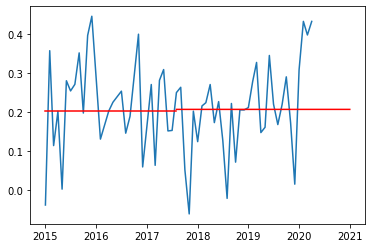

In [113]:
quotes_IND = quotes_IND.set_index(['quote_date'])
quotes_IND_before = quotes_IND.loc['2015-1-1' : '2017-7-31']
quotes_IND_after = quotes_IND.loc['2017-8-1' : '2020-12-31']
print(stats.ttest_ind(quotes_IND_before['Sentiment'], quotes_IND_after['Sentiment']))
print("Average India sentiment before legalization :", round(quotes_IND_before['Sentiment'].mean(),4), ", SD =", round(quotes_IND_before['Sentiment'].std(),4) , ", N =",quotes_IND_before['Sentiment'].size)
print("Average India sentiment after legalization :", round(quotes_IND_after['Sentiment'].mean(),4), ", SD =", round(quotes_IND_after['Sentiment'].std(),4) , ", N =",quotes_IND_after['Sentiment'].size)
print("Overall average India sentiment :", round(quotes_IND['Sentiment'].mean(),4), ", SD =", round(quotes_IND['Sentiment'].std(),4) , ", N =",quotes_IND['Sentiment'].size)
plt.plot(quotes_IND.groupby('quote_date').mean()["Sentiment"])
plt.plot(pd.date_range(start="2015-1-1",end="2017-7-31"),quotes_IND_before['Sentiment'].mean() * np.ones(1+(pd.to_datetime("2017-7-31")-pd.to_datetime("2015-1-1")).days),'r')
plt.plot(pd.date_range(start="2017-8-1",end="2020-12-31"),quotes_IND_after['Sentiment'].mean() *np.ones(1+(pd.to_datetime("2020-12-31")-pd.to_datetime("2017-8-1")).days),'r')

### Ireland

Ttest_indResult(statistic=0.6766871713722986, pvalue=0.4986981706452759)
Average Ireland sentiment before legalization : 0.1853 , SD = 0.5231 , N = 409
Average Ireland sentiment after legalization : 0.1653 , SD = 0.5188 , N = 1263
Overall average Ireland sentiment : 0.2053 , SD = 0.5559 , N = 2585


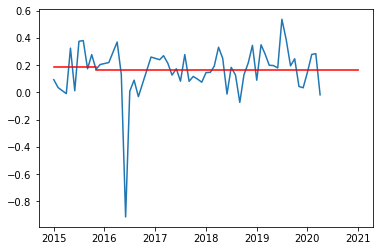

In [114]:
quotes_IRE = quotes_IRE.set_index(['quote_date'])
quotes_IRE_before = quotes_IRE.loc['2015-1-1' : '2015-10-31']
quotes_IRE_after = quotes_IRE.loc['2015-11-1' : '2020-12-31']
print(stats.ttest_ind(quotes_IRE_before['Sentiment'], quotes_IRE_after['Sentiment']))
print("Average Ireland sentiment before legalization :", round(quotes_IRE_before['Sentiment'].mean(),4), ", SD =", round(quotes_IRE_before['Sentiment'].std(),4) , ", N =",quotes_IRE_before['Sentiment'].size)
print("Average Ireland sentiment after legalization :", round(quotes_IRE_after['Sentiment'].mean(),4), ", SD =", round(quotes_IRE_after['Sentiment'].std(),4) , ", N =",quotes_IRE_after['Sentiment'].size)
print("Overall average Ireland sentiment :", round(quotes_IND['Sentiment'].mean(),4), ", SD =", round(quotes_IND['Sentiment'].std(),4) , ", N =",quotes_IND['Sentiment'].size)
plt.plot(quotes_IRE.groupby('quote_date').mean()["Sentiment"])
plt.plot(pd.date_range(start="2015-1-1",end="2015-10-31"),quotes_IRE_before['Sentiment'].mean() * np.ones(1+(pd.to_datetime("2015-10-31")-pd.to_datetime("2015-1-1")).days),'r')
plt.plot(pd.date_range(start="2015-11-1",end="2020-12-31"),quotes_IRE_after['Sentiment'].mean() *np.ones(1+(pd.to_datetime("2020-12-31")-pd.to_datetime("2015-11-1")).days),'r')

### Philippines (extension)

Recalling the periods detailed above :
- January 2015 - January 2016,
- February 2016 - February 2017,
- March 2017 - November 2017,
- December 2017 - May 2018,
- June 2018 - August 2019,
- September 2019 - December 2020.

Average Philippines sentiment in period 1 : 0.2952 , SD = 0.4827 , N = 330
Average Philippines sentiment in period 2 : 0.1823 , SD = 0.5092 , N = 265
Average Philippines sentiment in period 3 : 0.204 , SD = 0.4903 , N = 403
Average Philippines sentiment in period 4 : 0.2443 , SD = 0.4958 , N = 270
Average Philippines sentiment in period 5 : 0.218 , SD = 0.4962 , N = 569
Average Philippines sentiment in period 6 : 0.233 , SD = 0.4938 , N = 183
Overall average Philippines sentiment : 0.228 , SD = 0.4949 , N = 2020


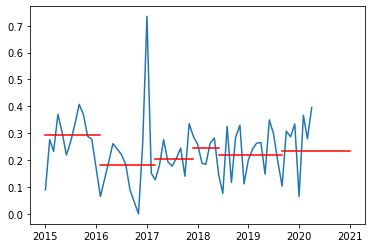

In [115]:
quotes_PHI = quotes_expanded[quotes_expanded['nationality'] == 'Philippines']
quotes_PHI = quotes_PHI.set_index(['quote_date'])
quotes_PHI_1 = quotes_PHI.loc['2015-1-1' : '2016-1-31']
quotes_PHI_2 = quotes_PHI.loc['2016-2-1' : '2017-2-28']
quotes_PHI_3 = quotes_PHI.loc['2017-3-1' : '2017-11-30']
quotes_PHI_4 = quotes_PHI.loc['2017-12-1' : '2018-5-31']
quotes_PHI_5 = quotes_PHI.loc['2018-6-1' : '2019-8-31']
quotes_PHI_6 = quotes_PHI.loc['2019-9-1' : '2020-12-31']
print("Average Philippines sentiment in period 1 :", round(quotes_PHI_1['Sentiment'].mean(),4), ", SD =", round(quotes_PHI_1['Sentiment'].std(),4) , ", N =",quotes_PHI_1['Sentiment'].size)
print("Average Philippines sentiment in period 2 :", round(quotes_PHI_2['Sentiment'].mean(),4), ", SD =", round(quotes_PHI_2['Sentiment'].std(),4) , ", N =",quotes_PHI_2['Sentiment'].size)
print("Average Philippines sentiment in period 3 :", round(quotes_PHI_3['Sentiment'].mean(),4), ", SD =", round(quotes_PHI_3['Sentiment'].std(),4) , ", N =",quotes_PHI_3['Sentiment'].size)
print("Average Philippines sentiment in period 4 :", round(quotes_PHI_4['Sentiment'].mean(),4), ", SD =", round(quotes_PHI_4['Sentiment'].std(),4) , ", N =",quotes_PHI_4['Sentiment'].size)
print("Average Philippines sentiment in period 5 :", round(quotes_PHI_5['Sentiment'].mean(),4), ", SD =", round(quotes_PHI_5['Sentiment'].std(),4) , ", N =",quotes_PHI_5['Sentiment'].size)
print("Average Philippines sentiment in period 6 :", round(quotes_PHI_6['Sentiment'].mean(),4), ", SD =", round(quotes_PHI_6['Sentiment'].std(),4) , ", N =",quotes_PHI_6['Sentiment'].size)
print("Overall average Philippines sentiment :", round(quotes_PHI['Sentiment'].mean(),4), ", SD =", round(quotes_PHI['Sentiment'].std(),4) , ", N =",quotes_PHI['Sentiment'].size)
plt.plot(quotes_PHI.groupby('quote_date').mean()["Sentiment"])
plt.plot(pd.date_range(start="2015-1-1",end="2016-1-31"),quotes_PHI_1['Sentiment'].mean() * np.ones(1+(pd.to_datetime("2016-1-31")-pd.to_datetime("2015-1-1")).days),'r')
plt.plot(pd.date_range(start="2016-2-1",end="2017-2-28"),quotes_PHI_2['Sentiment'].mean() *np.ones(1+(pd.to_datetime("2017-2-28")-pd.to_datetime("2016-2-1")).days),'r')
plt.plot(pd.date_range(start="2017-3-1",end="2017-11-30"),quotes_PHI_3['Sentiment'].mean() * np.ones(1+(pd.to_datetime("2017-11-30")-pd.to_datetime("2017-3-1")).days),'r')
plt.plot(pd.date_range(start="2017-12-1",end="2018-5-31"),quotes_PHI_4['Sentiment'].mean() *np.ones(1+(pd.to_datetime("2018-5-31")-pd.to_datetime("2017-12-1")).days),'r')
plt.plot(pd.date_range(start="2018-6-1",end="2019-8-31"),quotes_PHI_5['Sentiment'].mean() * np.ones(1+(pd.to_datetime("2019-8-31")-pd.to_datetime("2018-6-1")).days),'r')
plt.plot(pd.date_range(start="2019-9-1",end="2020-12-31"),quotes_PHI_6['Sentiment'].mean() *np.ones(1+(pd.to_datetime("2020-12-31")-pd.to_datetime("2019-9-1")).days),'r')

## Step 7 :

In [116]:
nationalities_short['Sentiment_mean'] =[round(quotes_USA['Sentiment'].mean(),4),round(quotes_AUS['Sentiment'].mean(),4),round(quotes_IND['Sentiment'].mean(),4),round(quotes_IRE['Sentiment'].mean(),4)]
nationalities_short['Sentiment_before'] = [round(quotes_USA_before['Sentiment'].mean(),4),round(quotes_AUS_before['Sentiment'].mean(),4),round(quotes_IND_before['Sentiment'].mean(),4),round(quotes_IRE_before['Sentiment'].mean(),4)]
nationalities_short['Sentiment_after'] = [round(quotes_USA_after['Sentiment'].mean(),4),round(quotes_AUS_after['Sentiment'].mean(),4),round(quotes_IND_after['Sentiment'].mean(),4),round(quotes_IRE_after['Sentiment'].mean(),4)]
nationalities_short['Sentiment_difference'] = nationalities_short['Sentiment_after'] - nationalities_short['Sentiment_before']
nationalities_short['Independence_p_value'] = [stats.ttest_ind(quotes_USA_before['Sentiment'], quotes_USA_after['Sentiment'])[1],stats.ttest_ind(quotes_AUS_before['Sentiment'], quotes_AUS_after['Sentiment'])[1],stats.ttest_ind(quotes_IND_before['Sentiment'], quotes_IND_after['Sentiment'])[1],stats.ttest_ind(quotes_IRE_before['Sentiment'], quotes_IRE_after['Sentiment'])[1]]
nationalities_short.head(4)

,Country,Counts,Legalization_date,Sentiment_mean,Sentiment_before,Sentiment_after,Sentiment_difference,Independence_p_value
0,United States of America,70307,2015-07-01,0.1227,0.1632,0.1179,-0.0453,6.837818e-12
1,Australia,7230,2017-12-01,0.1462,0.1635,0.1196,-0.0439,4.791265e-04
2,India,2585,2017-08-01,0.2053,0.2021,0.2068,0.0047,8.420934e-01
3,Ireland,1672,2015-11-01,0.1702,0.1853,0.1653,-0.0200,4.986982e-01


## Step 2 : Answering our research question 1 with the same-sex marriage related quotes

In [10]:
quotes_marriage = pd.read_pickle("same-sex-marriage-focus.pkl")
quotes_marriage = quotes_marriage.reset_index(drop=True)

df_time = quotes_marriage[['quote_year','quote_month']]
df_time['quote_day'] = np.ones(len(df_time), dtype = int)
df_time.columns = ['year', 'month', 'day']
df_time = pd.to_datetime(df_time)
quotes_marriage["quote_date"] = df_time
quotes_marriage = quotes_marriage.drop(['quote_year', 'quote_month','occupation'], axis=1)

quotes_marriage.head(10)

<ipython-input-10-71ca2aa33d9d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time['quote_day'] = np.ones(len(df_time), dtype = int)


,date_of_birth,nationality,gender,Speaker,Quote,Sentiment,Sentiment Label,quote_date
0,1971,United States of America,female,sarah kate ellis,"With this decision, loving and committed same-...",0.9354,Positive,2015-06-01
1,1971,United States of America,female,sarah kate ellis,"It's marriage equality, and it's a benchmark. ...",-0.1515,Negative,2015-06-01
2,1971,United States of America,female,sarah kate ellis,I think where we start to get into a slippery ...,0.9575,Positive,2015-06-01
3,1971,United States of America,female,sarah kate ellis,"But marriage equality is a benchmark, it is no...",0.0000,Neutral,2015-12-01
4,1971,United States of America,female,sarah kate ellis,2015 was a monumental year for the LGBT commun...,0.8402,Positive,2016-02-01
5,1971,United States of America,female,sarah kate ellis,warning shot to all LGBTQ Americans that the w...,-0.7430,Negative,2017-06-01
6,1971,United States of America,female,sarah kate ellis,You can look it up. I've given to American Uni...,0.0000,Neutral,2017-07-01
7,1971,United States of America,female,sarah kate ellis,The Texas Supreme Court's decision this mornin...,-0.3818,Negative,2017-06-01
8,1971,United States of America,female,sarah kate ellis,In a shameful haste to undermine marriage equa...,-0.6597,Negative,2017-04-01
9,1971,United States of America,female,sarah kate ellis,Republicans in the Senate just destroyed a ste...,0.5984,Positive,2017-04-01


In [11]:
nationalities = np.hstack(quotes_marriage.nationality.dropna().to_numpy())
nationalities_dict = dict(Counter(nationalities))
nationalities_dict = {'Country': list(nationalities_dict.keys()), 'Counts': list(nationalities_dict.values())}
nationalities_marriage = pd.DataFrame.from_dict(nationalities_dict)
nationalities_marriage = nationalities_marriage.sort_values(by='Counts', ascending=False)
nationalities_marriage.head(10)

,Country,Counts
0,United States of America,4173
1,Australia,1869
2,United Kingdom,797
4,Ireland,277
3,Canada,259
23,New Zealand,45
37,Taiwan,43
17,France,28
40,Japan,28
16,Germany,27


In [12]:
nationalities_short = nationalities_marriage[nationalities_marriage['Counts'] > 200]
nationalities_short = nationalities_short.reset_index(drop=True)
nationalities_short.head(10)

,Country,Counts
0,United States of America,4173
1,Australia,1869
2,United Kingdom,797
3,Ireland,277
4,Canada,259


We note Philippines' quotes finally did not contain much data related to same-sex marriage

In [13]:
nationalities_short = nationalities_short.drop(index=[2,4])
nationalities_short = nationalities_short.reset_index(drop=True)
nationalities_short.head(10)

,Country,Counts
0,United States of America,4173
1,Australia,1869
2,Ireland,277


In [14]:
dates = pd.DataFrame({'year':[2015,2017,2015],'month':[6,12,11],'day': [1,1,1]})
nationalities_short['Legalization_date'] = pd.to_datetime(dates)
nationalities_short.head(10)

,Country,Counts,Legalization_date
0,United States of America,4173,2015-06-01
1,Australia,1869,2017-12-01
2,Ireland,277,2015-11-01


In [15]:
quotes_USA = quotes_marriage[quotes_marriage['nationality'] == 'United States of America']
quotes_AUS = quotes_marriage[quotes_marriage['nationality'] == 'Australia']
quotes_IRE = quotes_marriage[quotes_marriage['nationality'] == 'Ireland']

### United States of America

Ttest_indResult(statistic=2.1003945537977526, pvalue=0.035754039733282214)
Average USA sentiment before legalization : 0.2188 , SD = 0.5139 , N = 1213
Average USA sentiment after legalization : 0.1822 , SD = 0.5107 , N = 2960
Overall average USA sentiment : 0.1928 , SD = 0.5119 , N = 4173


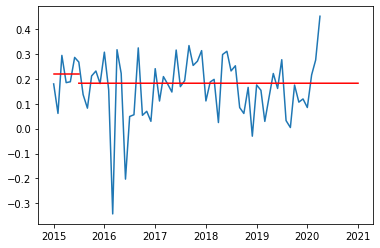

In [16]:
quotes_USA = quotes_USA.set_index(['quote_date'])
quotes_USA_before = quotes_USA.loc['2015-1-1' : '2015-6-30']
quotes_USA_after = quotes_USA.loc['2015-7-1' : '2020-12-31']
print(stats.ttest_ind(quotes_USA_before['Sentiment'], quotes_USA_after['Sentiment']))
print("Average USA sentiment before legalization :", round(quotes_USA_before['Sentiment'].mean(),4), ", SD =", round(quotes_USA_before['Sentiment'].std(),4) , ", N =",quotes_USA_before['Sentiment'].size)
print("Average USA sentiment after legalization :", round(quotes_USA_after['Sentiment'].mean(),4), ", SD =", round(quotes_USA_after['Sentiment'].std(),4) , ", N =",quotes_USA_after['Sentiment'].size)
print("Overall average USA sentiment :", round(quotes_USA['Sentiment'].mean(),4), ", SD =", round(quotes_USA['Sentiment'].std(),4) , ", N =",quotes_USA['Sentiment'].size)
plt.plot(quotes_USA.groupby('quote_date').mean()["Sentiment"])
plt.plot(pd.date_range(start="2015-1-1",end="2015-6-30"),quotes_USA_before['Sentiment'].mean() * np.ones(1+(pd.to_datetime("2015-6-30")-pd.to_datetime("2015-1-1")).days),'r')
plt.plot(pd.date_range(start="2015-7-1",end="2020-12-31"),quotes_USA_after['Sentiment'].mean() *np.ones(1+(pd.to_datetime("2020-12-31")-pd.to_datetime("2015-7-1")).days),'r')

### Australia

Ttest_indResult(statistic=1.743277429704311, pvalue=0.08144978000881772)
Average Australia sentiment before legalization : 0.2457 , SD = 0.468 , N = 1575
Average Australia sentiment after legalization : 0.1937 , SD = 0.4781 , N = 294
Overall average Australia sentiment : 0.2375 , SD = 0.4698 , N = 1869


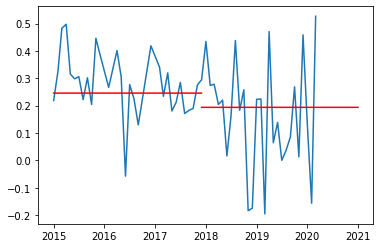

In [17]:
quotes_AUS = quotes_AUS.set_index(['quote_date'])
quotes_AUS_before = quotes_AUS.loc['2015-1-1' : '2017-11-30']
quotes_AUS_after = quotes_AUS.loc['2017-12-1' : '2020-12-31']
print(stats.ttest_ind(quotes_AUS_before['Sentiment'], quotes_AUS_after['Sentiment']))
print("Average Australia sentiment before legalization :", round(quotes_AUS_before['Sentiment'].mean(),4), ", SD =", round(quotes_AUS_before['Sentiment'].std(),4) , ", N =",quotes_AUS_before['Sentiment'].size)
print("Average Australia sentiment after legalization :", round(quotes_AUS_after['Sentiment'].mean(),4), ", SD =", round(quotes_AUS_after['Sentiment'].std(),4) , ", N =",quotes_AUS_after['Sentiment'].size)
print("Overall average Australia sentiment :", round(quotes_AUS['Sentiment'].mean(),4), ", SD =", round(quotes_AUS['Sentiment'].std(),4) , ", N =",quotes_AUS['Sentiment'].size)
plt.plot(quotes_AUS.groupby('quote_date').mean()["Sentiment"])
plt.plot(pd.date_range(start="2015-1-1",end="2017-11-30"),quotes_AUS_before['Sentiment'].mean() * np.ones(1+(pd.to_datetime("2017-11-30")-pd.to_datetime("2015-1-1")).days),'r')
plt.plot(pd.date_range(start="2017-12-1",end="2020-12-31"),quotes_AUS_after['Sentiment'].mean() *np.ones(1+(pd.to_datetime("2020-12-31")-pd.to_datetime("2017-12-1")).days),'r')

### Ireland

In [18]:
quotes_IRE = quotes_IRE.set_index(['quote_date'])
quotes_IRE_before = quotes_IRE.loc['2015-1-1' : '2015-10-31']
quotes_IRE_after = quotes_IRE.loc['2015-11-1' : '2020-12-31']
print(stats.ttest_ind(quotes_IRE_before['Sentiment'], quotes_IRE_after['Sentiment']))
print("Average Ireland sentiment before legalization :", round(quotes_IRE_before['Sentiment'].mean(),4), ", SD =", round(quotes_IRE_before['Sentiment'].std(),4) , ", N =",quotes_IRE_before['Sentiment'].size)
print("Average Ireland sentiment after legalization :", round(quotes_IRE_after['Sentiment'].mean(),4), ", SD =", round(quotes_IRE_after['Sentiment'].std(),4) , ", N =",quotes_IRE_after['Sentiment'].size)
print("Overall average Ireland sentiment :", round(quotes_IND['Sentiment'].mean(),4), ", SD =", round(quotes_IND['Sentiment'].std(),4) , ", N =",quotes_IND['Sentiment'].size)
plt.plot(quotes_IRE.groupby('quote_date').mean()["Sentiment"])
plt.plot(pd.date_range(start="2015-1-1",end="2015-10-31"),quotes_IRE_before['Sentiment'].mean() * np.ones(1+(pd.to_datetime("2015-10-31")-pd.to_datetime("2015-1-1")).days),'r')
plt.plot(pd.date_range(start="2015-11-1",end="2020-12-31"),quotes_IRE_after['Sentiment'].mean() *np.ones(1+(pd.to_datetime("2020-12-31")-pd.to_datetime("2015-11-1")).days),'r')

Ttest_indResult(statistic=-3.628508772386712, pvalue=0.00033976966782006863)
Average Ireland sentiment before legalization : 0.0953 , SD = 0.5293 , N = 77
Average Ireland sentiment after legalization : 0.3237 , SD = 0.4443 , N = 200


NameError: name 'quotes_IND' is not defined

### Conclusion

In [19]:
nationalities_short['Sentiment_mean'] =[round(quotes_USA['Sentiment'].mean(),4),round(quotes_AUS['Sentiment'].mean(),4),round(quotes_IRE['Sentiment'].mean(),4)]
nationalities_short['Sentiment_before'] = [round(quotes_USA_before['Sentiment'].mean(),4),round(quotes_AUS_before['Sentiment'].mean(),4),round(quotes_IRE_before['Sentiment'].mean(),4)]
nationalities_short['Sentiment_after'] = [round(quotes_USA_after['Sentiment'].mean(),4),round(quotes_AUS_after['Sentiment'].mean(),4),round(quotes_IRE_after['Sentiment'].mean(),4)]
nationalities_short['Sentiment_difference'] = nationalities_short['Sentiment_after'] - nationalities_short['Sentiment_before']
nationalities_short['Independence_p_value'] = [stats.ttest_ind(quotes_USA_before['Sentiment'], quotes_USA_after['Sentiment'])[1],stats.ttest_ind(quotes_AUS_before['Sentiment'], quotes_AUS_after['Sentiment'])[1],stats.ttest_ind(quotes_IRE_before['Sentiment'], quotes_IRE_after['Sentiment'])[1]]
nationalities_short.head(4)

,Country,Counts,Legalization_date,Sentiment_mean,Sentiment_before,Sentiment_after,Sentiment_difference,Independence_p_value
0,United States of America,4173,2015-06-01,0.1928,0.2188,0.1822,-0.0366,0.035754
1,Australia,1869,2017-12-01,0.2375,0.2457,0.1937,-0.0520,0.081450
2,Ireland,277,2015-11-01,0.2603,0.0953,0.3237,0.2284,0.000340


In [20]:
quotes_UK = quotes_marriage[quotes_marriage['nationality'] == 'United Kingdom']
quotes_CAN = quotes_marriage[quotes_marriage['nationality'] == 'Canada']
print("Average UK sentiment", round(quotes_UK['Sentiment'].mean(),4))
print("Average Canada sentiment", round(quotes_CAN['Sentiment'].mean(),4))

Average UK sentiment 0.2224
Average Canada sentiment 0.2561


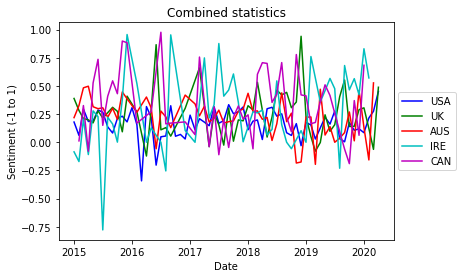

In [21]:
plt.plot(quotes_USA.groupby('quote_date').mean()["Sentiment"], 'b', label = 'USA')
plt.plot(quotes_UK.groupby('quote_date').mean()["Sentiment"], 'g', label = 'UK')
plt.plot(quotes_AUS.groupby('quote_date').mean()["Sentiment"], 'r', label = 'AUS')
plt.plot(quotes_IRE.groupby('quote_date').mean()["Sentiment"], 'c', label = 'IRE')
plt.plot(quotes_CAN.groupby('quote_date').mean()["Sentiment"], 'm', label = 'CAN')
plt.title('Combined statistics')
plt.xlabel('Date')
plt.ylabel('Sentiment (-1 to 1)')
plt.legend(loc='center right', bbox_to_anchor=(1.2, 0.5))

plt.savefig('Q1_plot_all.png',
            dpi=600, 
            format='png',
            #bbox_extra_artists=(plt.legend),
            bbox_inches='tight')

In [25]:
import pandas as pd

from bokeh.palettes import Spectral4
from bokeh.models import Title
from bokeh.plotting import figure, output_file, show
from bokeh.sampledata.stocks import AAPL, GOOG, IBM, MSFT

p = figure(width=800, height=250, x_axis_type="datetime", x_axis_label="Date", y_axis_label='Sentiment (-1 to 1)')
p.add_layout(Title(text='Click on legend entries to hide the corresponding lines', text_font_style="italic"), 'above')
p.add_layout(Title(text="Combined statistics", text_font_size="16pt"), 'above')

usa = quotes_USA.groupby('quote_date').mean()["Sentiment"]
uk = quotes_UK.groupby('quote_date').mean()["Sentiment"]
aus = quotes_AUS.groupby('quote_date').mean()["Sentiment"]
ire = quotes_IRE.groupby('quote_date').mean()["Sentiment"]
can = quotes_CAN.groupby('quote_date').mean()["Sentiment"]

p.line(usa.index, usa.values, line_width=2, color=Spectral4[0], alpha=0.8, legend_label="USA")
p.line(uk.index, uk.values, line_width=2, color=Spectral4[1], alpha=0.8, legend_label="UK")
p.line(aus.index, aus.values, line_width=2, color=Spectral4[2], alpha=0.8, legend_label="AUS")
p.line(ire.index, ire.values, line_width=2, color=Spectral4[3], alpha=0.8, legend_label="IRE")
p.line(can.index, can.values, line_width=2, color="violet", alpha=0.8, legend_label="CAN")

p.legend.location = "top_left"
p.add_layout(p.legend[0], 'right')
p.legend.click_policy="hide"

output_file("interactive_legend.html", title="interactive_legend.py example")

show(p)

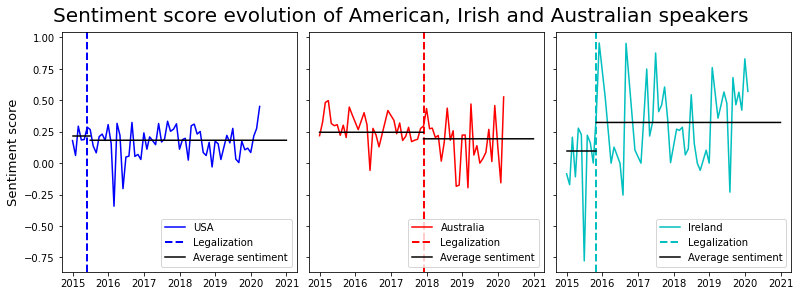

In [22]:
fig, ax = plt.subplots(1,3, sharey = True, constrained_layout=True,figsize=(11,4))
plt.suptitle('Sentiment score evolution of American, Irish and Australian speakers', fontsize=20)
#plt.set_xlabel('Date',fontsize = 13)
#plt.plot(quotes_USA.groupby('quote_date').mean()["Sentiment"], 'b', label = 'USA', ax = ax[0])

ax[0].plot(quotes_USA.groupby('quote_date').mean()["Sentiment"], 'b', label = 'USA')
ax[0].axvline(pd.to_datetime('2015-06-01'), color="blue", linestyle="--", lw=2, label='Legalization')
ax[0].plot(pd.date_range(start="2015-1-1",end="2015-6-30"),quotes_USA_before['Sentiment'].mean() * np.ones(1+(pd.to_datetime("2015-6-30")-pd.to_datetime("2015-1-1")).days),'k')
ax[0].plot(pd.date_range(start="2015-7-1",end="2020-12-31"),quotes_USA_after['Sentiment'].mean() *np.ones(1+(pd.to_datetime("2020-12-31")-pd.to_datetime("2015-7-1")).days),'k', label = 'Average sentiment')
ax[0].legend(loc = 'lower right')
ax[0].set_ylabel('Sentiment score',fontsize = 13)

ax[1].plot(quotes_AUS.groupby('quote_date').mean()["Sentiment"], 'r', label = 'Australia')
ax[1].axvline(pd.to_datetime('2017-12-01'), color="red", linestyle="--", lw=2, label='Legalization')
ax[1].plot(pd.date_range(start="2015-1-1",end="2017-11-30"),quotes_AUS_before['Sentiment'].mean() * np.ones(1+(pd.to_datetime("2017-11-30")-pd.to_datetime("2015-1-1")).days),'k')
ax[1].plot(pd.date_range(start="2017-12-1",end="2020-12-31"),quotes_AUS_after['Sentiment'].mean() *np.ones(1+(pd.to_datetime("2020-12-31")-pd.to_datetime("2017-12-1")).days),'k', label = 'Average sentiment')
#ax[1].set_xlabel('Date',fontsize = 13)
ax[1].legend(loc = 'lower right')

ax[2].plot(quotes_IRE.groupby('quote_date').mean()["Sentiment"], 'c', label = 'Ireland')
ax[2].axvline(pd.to_datetime('2015-11-01'), color="c", linestyle="--", lw=2, label='Legalization')
ax[2].plot(pd.date_range(start="2015-1-1",end="2015-10-31"),quotes_IRE_before['Sentiment'].mean() * np.ones(1+(pd.to_datetime("2015-10-31")-pd.to_datetime("2015-1-1")).days),'k')
ax[2].plot(pd.date_range(start="2015-11-1",end="2020-12-31"),quotes_IRE_after['Sentiment'].mean() *np.ones(1+(pd.to_datetime("2020-12-31")-pd.to_datetime("2015-11-1")).days),'k', label = 'Average sentiment')
#ax[2].set_xlabel('Date',fontsize = 13)
ax[2].legend(loc = 'lower right')

plt.savefig('Q1_merged_plot_all.png',
            dpi=600, 
            format='png',
            #bbox_extra_artists=(plt.legend),
            bbox_inches='tight')

### Trying another legend set :

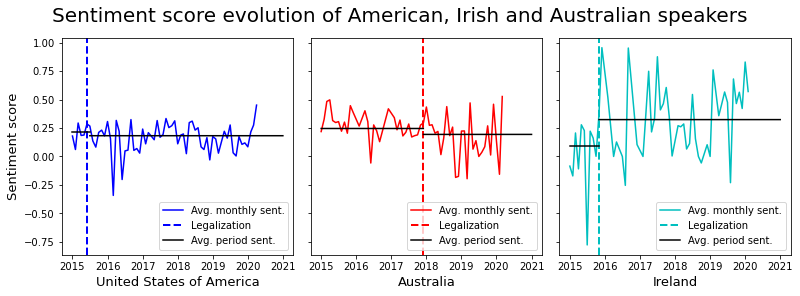

In [130]:
fig, ax = plt.subplots(1,3, sharey = True, constrained_layout=True,figsize=(11,4))
plt.suptitle('Sentiment score evolution of American, Irish and Australian speakers', fontsize=20)
#plt.set_xlabel('Date',fontsize = 13)
#plt.plot(quotes_USA.groupby('quote_date').mean()["Sentiment"], 'b', label = 'USA', ax = ax[0])

ax[0].plot(quotes_USA.groupby('quote_date').mean()["Sentiment"], 'b', label = 'Avg. monthly sent.')
ax[0].axvline(pd.to_datetime('2015-06-01'), color="blue", linestyle="--", lw=2, label='Legalization')
ax[0].plot(pd.date_range(start="2015-1-1",end="2015-6-30"),quotes_USA_before['Sentiment'].mean() * np.ones(1+(pd.to_datetime("2015-6-30")-pd.to_datetime("2015-1-1")).days),'k')
ax[0].plot(pd.date_range(start="2015-7-1",end="2020-12-31"),quotes_USA_after['Sentiment'].mean() *np.ones(1+(pd.to_datetime("2020-12-31")-pd.to_datetime("2015-7-1")).days),'k', label = 'Avg. period sent.')
ax[0].legend(loc = 'lower right')
ax[0].set_xlabel('United States of America',fontsize = 13)
ax[0].set_ylabel('Sentiment score',fontsize = 13)

ax[1].plot(quotes_AUS.groupby('quote_date').mean()["Sentiment"], 'r', label = 'Avg. monthly sent.')
ax[1].axvline(pd.to_datetime('2017-12-01'), color="red", linestyle="--", lw=2, label='Legalization')
ax[1].plot(pd.date_range(start="2015-1-1",end="2017-11-30"),quotes_AUS_before['Sentiment'].mean() * np.ones(1+(pd.to_datetime("2017-11-30")-pd.to_datetime("2015-1-1")).days),'k')
ax[1].plot(pd.date_range(start="2017-12-1",end="2020-12-31"),quotes_AUS_after['Sentiment'].mean() *np.ones(1+(pd.to_datetime("2020-12-31")-pd.to_datetime("2017-12-1")).days),'k', label = 'Avg. period sent.')
ax[1].set_xlabel('Australia',fontsize = 13)
ax[1].legend(loc = 'lower right')

ax[2].plot(quotes_IRE.groupby('quote_date').mean()["Sentiment"], 'c', label = 'Avg. monthly sent.')
ax[2].axvline(pd.to_datetime('2015-11-01'), color="c", linestyle="--", lw=2, label='Legalization')
ax[2].plot(pd.date_range(start="2015-1-1",end="2015-10-31"),quotes_IRE_before['Sentiment'].mean() * np.ones(1+(pd.to_datetime("2015-10-31")-pd.to_datetime("2015-1-1")).days),'k')
ax[2].plot(pd.date_range(start="2015-11-1",end="2020-12-31"),quotes_IRE_after['Sentiment'].mean() *np.ones(1+(pd.to_datetime("2020-12-31")-pd.to_datetime("2015-11-1")).days),'k', label = 'Avg. period sent.')
ax[2].set_xlabel('Ireland',fontsize = 13)
ax[2].legend(loc = 'lower right')

#plt.savefig('Q1_merged_plot_all_W.png',
            #dpi=600, 
            #format='png',
            #bbox_extra_artists=(plt.legend),
            #bbox_inches='tight')

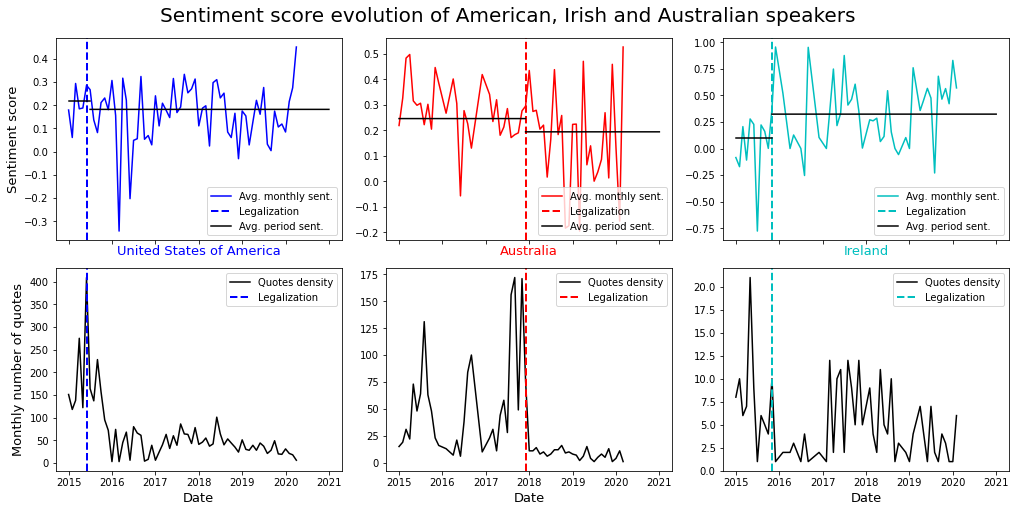

In [131]:
fig, ax = plt.subplots(2,3, sharex=True, constrained_layout=True,figsize=(14,7))
plt.suptitle('Sentiment score evolution of American, Irish and Australian speakers', fontsize=20)

ax[0,0].plot(quotes_USA.groupby('quote_date').mean()["Sentiment"], 'b', label = 'Avg. monthly sent.')
ax[0,0].axvline(pd.to_datetime('2015-06-01'), color="blue", linestyle="--", lw=2, label='Legalization')
ax[0,0].plot(pd.date_range(start="2015-1-1",end="2015-6-30"),quotes_USA_before['Sentiment'].mean() * np.ones(1+(pd.to_datetime("2015-6-30")-pd.to_datetime("2015-1-1")).days),'k')
ax[0,0].plot(pd.date_range(start="2015-7-1",end="2020-12-31"),quotes_USA_after['Sentiment'].mean() *np.ones(1+(pd.to_datetime("2020-12-31")-pd.to_datetime("2015-7-1")).days),'k', label = 'Avg. period sent.')
ax[0,0].legend(loc = 'lower right')
ax[0,0].set_xlabel('United States of America',fontsize = 13)
ax[0,0].xaxis.label.set_color('b')
ax[0,0].set_ylabel('Sentiment score',fontsize = 13)

ax[0,1].plot(quotes_AUS.groupby('quote_date').mean()["Sentiment"], 'r', label = 'Avg. monthly sent.')
ax[0,1].axvline(pd.to_datetime('2017-12-01'), color="red", linestyle="--", lw=2, label='Legalization')
ax[0,1].plot(pd.date_range(start="2015-1-1",end="2017-11-30"),quotes_AUS_before['Sentiment'].mean() * np.ones(1+(pd.to_datetime("2017-11-30")-pd.to_datetime("2015-1-1")).days),'k')
ax[0,1].plot(pd.date_range(start="2017-12-1",end="2020-12-31"),quotes_AUS_after['Sentiment'].mean() *np.ones(1+(pd.to_datetime("2020-12-31")-pd.to_datetime("2017-12-1")).days),'k', label = 'Avg. period sent.')
ax[0,1].set_xlabel('Australia',fontsize = 13)
ax[0,1].xaxis.label.set_color('r')
ax[0,1].legend(loc = 'lower right')

ax[0,2].plot(quotes_IRE.groupby('quote_date').mean()["Sentiment"], 'c', label = 'Avg. monthly sent.')
ax[0,2].axvline(pd.to_datetime('2015-11-01'), color="c", linestyle="--", lw=2, label='Legalization')
ax[0,2].plot(pd.date_range(start="2015-1-1",end="2015-10-31"),quotes_IRE_before['Sentiment'].mean() * np.ones(1+(pd.to_datetime("2015-10-31")-pd.to_datetime("2015-1-1")).days),'k')
ax[0,2].plot(pd.date_range(start="2015-11-1",end="2020-12-31"),quotes_IRE_after['Sentiment'].mean() *np.ones(1+(pd.to_datetime("2020-12-31")-pd.to_datetime("2015-11-1")).days),'k', label = 'Avg. period sent.')
ax[0,2].set_xlabel('Ireland',fontsize = 13)
ax[0,2].xaxis.label.set_color('c')
ax[0,2].legend(loc = 'lower right')
            
ax[1,0].plot(quotes_USA.groupby('quote_date')['date_of_birth'].count(), 'k', label = 'Quotes density')
ax[1,0].axvline(pd.to_datetime('2015-06-01'), color="blue", linestyle="--", lw=2, label='Legalization')
ax[1,0].legend(loc = 'upper right')
ax[1,0].set_xlabel('Date',fontsize = 13)
ax[1,0].set_ylabel('Monthly number of quotes',fontsize = 13)

ax[1,1].plot(quotes_AUS.groupby('quote_date')['date_of_birth'].count(), 'k',label = 'Quotes density')
ax[1,1].axvline(pd.to_datetime('2017-12-01'), color="red", linestyle="--", lw=2, label='Legalization')
ax[1,1].legend(loc = 'upper right')
ax[1,1].set_xlabel('Date',fontsize = 13)

ax[1,2].plot(quotes_IRE.groupby('quote_date')['date_of_birth'].count(), 'k', label = 'Quotes density')
ax[1,2].axvline(pd.to_datetime('2015-11-01'), color="c", linestyle="--", lw=2, label='Legalization')
ax[1,2].legend(loc = 'upper right')
ax[1,2].set_xlabel('Date',fontsize = 13)

plt.savefig('Q1_merged_plot_all_W.png',
            dpi=600, 
            format='png',
            bbox_inches='tight')

### Philippines (extension)

Average Philippines sentiment in period 1 : 0.4762 , SD = 0.1926 , N = 2
Average Philippines sentiment in period 2 : 0.6644 , SD = 0.4802 , N = 4
Average Philippines sentiment in period 3 : -0.1334 , SD = 0.3479 , N = 3
Average Philippines sentiment in period 4 : 0.7269 , SD = nan , N = 1
Average Philippines sentiment in period 5 : -0.1858 , SD = 0.4804 , N = 4
Average Philippines sentiment in period 6 : 0.124 , SD = 0.7212 , N = 3
Overall average Philippines sentiment : 0.2097 , SD = 0.5557 , N = 17


<ipython-input-132-394160278075>:3: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  quotes_PHI_1 = quotes_PHI.loc['2015-1-1' : '2016-1-31']
<ipython-input-132-394160278075>:6: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  quotes_PHI_4 = quotes_PHI.loc['2017-12-1' : '2018-5-31']


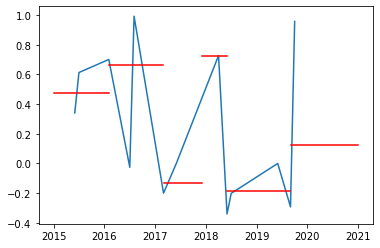

In [132]:
quotes_PHI = quotes_marriage[quotes_marriage['nationality'] == 'Philippines']
quotes_PHI = quotes_PHI.set_index(['quote_date'])
quotes_PHI_1 = quotes_PHI.loc['2015-1-1' : '2016-1-31']
quotes_PHI_2 = quotes_PHI.loc['2016-2-1' : '2017-2-28']
quotes_PHI_3 = quotes_PHI.loc['2017-3-1' : '2017-11-30']
quotes_PHI_4 = quotes_PHI.loc['2017-12-1' : '2018-5-31']
quotes_PHI_5 = quotes_PHI.loc['2018-6-1' : '2019-8-31']
quotes_PHI_6 = quotes_PHI.loc['2019-9-1' : '2020-12-31']
print("Average Philippines sentiment in period 1 :", round(quotes_PHI_1['Sentiment'].mean(),4), ", SD =", round(quotes_PHI_1['Sentiment'].std(),4) , ", N =",quotes_PHI_1['Sentiment'].size)
print("Average Philippines sentiment in period 2 :", round(quotes_PHI_2['Sentiment'].mean(),4), ", SD =", round(quotes_PHI_2['Sentiment'].std(),4) , ", N =",quotes_PHI_2['Sentiment'].size)
print("Average Philippines sentiment in period 3 :", round(quotes_PHI_3['Sentiment'].mean(),4), ", SD =", round(quotes_PHI_3['Sentiment'].std(),4) , ", N =",quotes_PHI_3['Sentiment'].size)
print("Average Philippines sentiment in period 4 :", round(quotes_PHI_4['Sentiment'].mean(),4), ", SD =", round(quotes_PHI_4['Sentiment'].std(),4) , ", N =",quotes_PHI_4['Sentiment'].size)
print("Average Philippines sentiment in period 5 :", round(quotes_PHI_5['Sentiment'].mean(),4), ", SD =", round(quotes_PHI_5['Sentiment'].std(),4) , ", N =",quotes_PHI_5['Sentiment'].size)
print("Average Philippines sentiment in period 6 :", round(quotes_PHI_6['Sentiment'].mean(),4), ", SD =", round(quotes_PHI_6['Sentiment'].std(),4) , ", N =",quotes_PHI_6['Sentiment'].size)
print("Overall average Philippines sentiment :", round(quotes_PHI['Sentiment'].mean(),4), ", SD =", round(quotes_PHI['Sentiment'].std(),4) , ", N =",quotes_PHI['Sentiment'].size)
plt.plot(quotes_PHI.groupby('quote_date').mean()["Sentiment"])
plt.plot(pd.date_range(start="2015-1-1",end="2016-1-31"),quotes_PHI_1['Sentiment'].mean() * np.ones(1+(pd.to_datetime("2016-1-31")-pd.to_datetime("2015-1-1")).days),'r')
plt.plot(pd.date_range(start="2016-2-1",end="2017-2-28"),quotes_PHI_2['Sentiment'].mean() *np.ones(1+(pd.to_datetime("2017-2-28")-pd.to_datetime("2016-2-1")).days),'r')
plt.plot(pd.date_range(start="2017-3-1",end="2017-11-30"),quotes_PHI_3['Sentiment'].mean() * np.ones(1+(pd.to_datetime("2017-11-30")-pd.to_datetime("2017-3-1")).days),'r')
plt.plot(pd.date_range(start="2017-12-1",end="2018-5-31"),quotes_PHI_4['Sentiment'].mean() *np.ones(1+(pd.to_datetime("2018-5-31")-pd.to_datetime("2017-12-1")).days),'r')
plt.plot(pd.date_range(start="2018-6-1",end="2019-8-31"),quotes_PHI_5['Sentiment'].mean() * np.ones(1+(pd.to_datetime("2019-8-31")-pd.to_datetime("2018-6-1")).days),'r')
plt.plot(pd.date_range(start="2019-9-1",end="2020-12-31"),quotes_PHI_6['Sentiment'].mean() *np.ones(1+(pd.to_datetime("2020-12-31")-pd.to_datetime("2019-9-1")).days),'r')

The number of quotes here is clearly not sufficient...